In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
from voting_mechanism_design.agents.quorum_badgeholder import QuorumBadgeholder, QuorumBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.threshold_and_aggregate import ThresholdAndAggregate
from voting_mechanism_design.sim import RoundSimulation

import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

In [3]:
# Round design variables
total_funds = 100
min_vote = 0
max_vote = 16

In [9]:
# create badgeholder population
n = 10
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,  
        max_vote=max_vote,
        # TODO: these should be random variables
        laziness=1,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

#print(len(badgeholders.badgeholders))
#print(badgeholder_list)

[<voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C00579D0>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C0057B50>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C0057D60>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C00577C0>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C0057760>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C00578B0>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C0057E20>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C00577F0>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C0057970>, <voting_mechanism_design.agents.quorum_badgeholder.QuorumBadgeholder object at 0x00000131C0057850>]

In [6]:
# create projects
N = 50
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,  # TODO: this should be a random variable              #was this supposed to be a vector? leave for now
        owner_id=None,  # used for COI modeling
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

#print(project_population.num_projects)

In [7]:
# instantiate a funding model
fund_distribution_model = ThresholdAndAggregate()

In [11]:
badgeholders.reset_all()  # Call this before each simulation run dont think this is important anymore but im leaving it in

# create and run a simulation
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)

projects = project_population.get_projects()

simulation_obj.run(cast_votes_kwargs={'projects': projects})


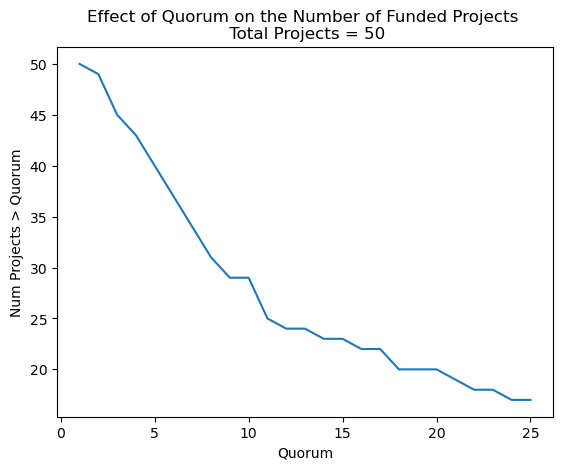

In [12]:
####Getting metrics
def count_projects_meeting_quorum(project_vote_counts, quorum):
    return sum(1 for votes in project_vote_counts.values() if votes >= quorum)

#Get votes 
all_votes = simulation_obj.badgeholder_population.get_all_votes()
project_vote_counts = defaultdict(int) # initialize dictionary to count votes
for vote in all_votes: #aggregating votes
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0

#Placeholders
quorum_vec = list(np.arange(1, 26))
project_pass_vec = []

#Counting projects meeting the variable quorum
for q in quorum_vec:
    num_projects_meeting_quorum = count_projects_meeting_quorum(project_vote_counts, q)
    project_pass_vec.append(num_projects_meeting_quorum)

# Plot the results
plt.figure()
plt.plot(quorum_vec, project_pass_vec)
plt.xlabel('Quorum')
plt.ylabel('Num Projects > Quorum')
plt.title('Effect of Quorum on the Number of Funded Projects \n Total Projects = 50')
plt.show()

In [9]:
####Same thing but with multiple simulation and more similar to original code 

#Placeholders
quorum_vec = list(np.arange(1, 26))
project_pass_vec = []

for q in quorum_vec: #Alternitavely we could just have the simulation outside the loop for efficiecy
    #Configuring & runnning Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Counting votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Count projects meeting the quorum
    num_projects_meeting_quorum = count_projects_meeting_quorum(project_vote_counts, q)
    project_pass_vec.append(num_projects_meeting_quorum)

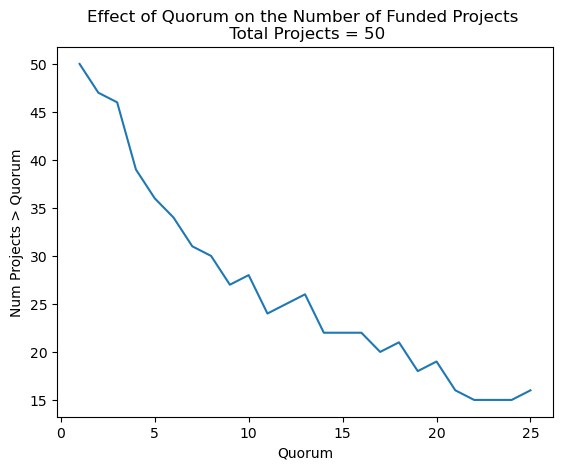

In [10]:
# Plot the results
plt.figure()
plt.plot(quorum_vec, project_pass_vec)
plt.xlabel('Quorum')
plt.ylabel('Num Projects > Quorum')
plt.title('Effect of Quorum on the Number of Funded Projects \n Total Projects = 50')
plt.show()

In [11]:
#####Graph 2

score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this 
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

for score_fn, q in sim_configs:
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

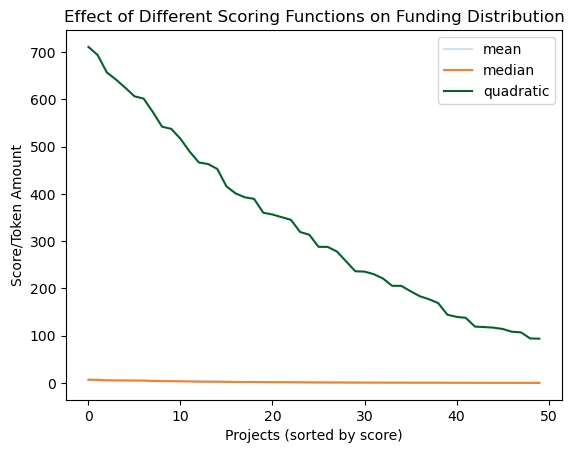

In [12]:
# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()

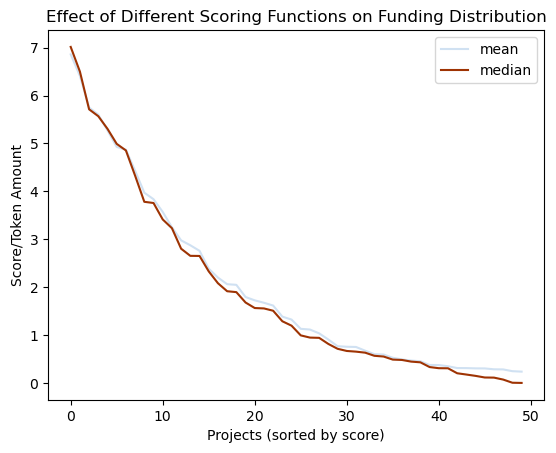

In [13]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median']#, 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in sim_configs:
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 42.00it/s]


Project 0 (mean): 6.92733647180612
Project 1 (mean): 1.109689181350533
Project 2 (mean): 1.0251413609387972
Project 3 (mean): 0.9020097302631287
Project 4 (mean): 0.7586632903703656
Project 5 (mean): 0.7623116115274915
Project 6 (mean): 0.7516902624231767
Project 7 (mean): 0.6741231111741032
Project 8 (mean): 0.606873576979771
Project 9 (mean): 0.5856530818018575
Project 10 (mean): 0.5216421536950098
Project 11 (mean): 0.46699926471442926
Project 12 (mean): 0.3049806941197623
Project 13 (mean): 0.4482482960792821
Project 14 (mean): 0.3759526321708679
Project 15 (mean): 0.34935922130434405
Project 16 (mean): 0.30934715070253105
Project 17 (mean): 0.30659724355563467
Project 18 (mean): 0.27748262356796816
Project 19 (mean): 0.2378617407390892
Project 20 (mean): 0.2810984302036106
Project 21 (mean): 0.24815813427315886
Project 22 (mean): 0.2972625883220041
Project 23 (mean): 1.1181663724797255
Project 24 (mean): 1.3247884527917324
Project 25 (mean): 1.3724153869285716
Project 26 (mean): 1

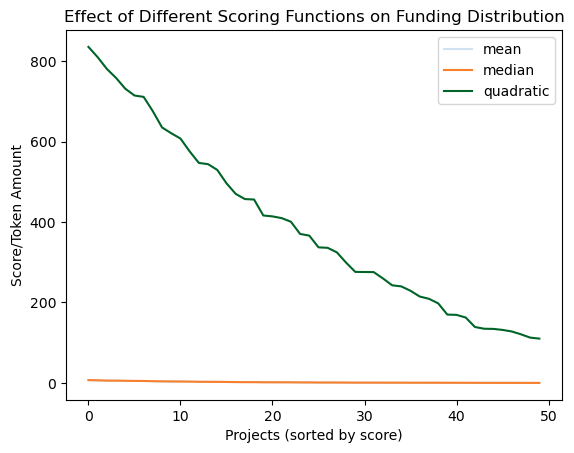

In [14]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in tqdm(sim_configs):
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
        print(f"Project {project.project_id} ({score_fn}): {score}")  # Debugging line
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


  0%|                                                                                                         | 0/3 [00:00<?, ?it/s]c:\users\martingale guest\documents\github\voting_mechanism_design\voting_mechanism_design\agents\quorum_badgeholder.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  max_vote_per_project = (badgeholder.total_funds * badgeholder.laziness_factor) / np.sqrt(remaining_votes)
c:\users\martingale guest\documents\github\voting_mechanism_design\voting_mechanism_design\agents\quorum_badgeholder.py:93: RuntimeWarning: invalid value encountered in sqrt
  max_vote_per_project = (badgeholder.total_funds * badgeholder.laziness_factor) / np.sqrt(remaining_votes)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.96it/s]


Project 0 votes: [2.2827492147498427, 7.2039573450414425, 1.9999081752132593, 12.219155587678424, 5.764851281238999, 12.877498788613973, 8.737488407377613, 1.999786849582409, 10.256630063197594, 0.04238170097633076, 8.64313934235164, 3.433243052814634, 11.258820512267723, 12.730628309509834, 2.3900191653603047, 12.713425576458762, 10.795573112358227, 12.103178889782994, 8.61241088590745, 11.483420239409712, 13.36209572887028, 1.4537459883287924, 10.194179475190102, 6.332319889213126, 11.805049525479989, 9.278555581031746, 13.707452521724328, 8.160853019921218, 2.566459272901693, 11.073743147277456, 8.597456883174933, 12.64700264630466, 10.65795353037785, 12.357827278390708, 7.091924027533049, 2.3639446022024675, 10.325502835655204, 1.0144026970054214, 13.979949260414216, 2.0374322120000805, 7.237730413731787, 5.181527333396091, 13.421921098624152, 6.8856957566288886, 10.306752536106437, 4.280448269176154, 7.330377199435913, 2.923811377615995, 5.41097930789291, 13.156469920259275, 9.971

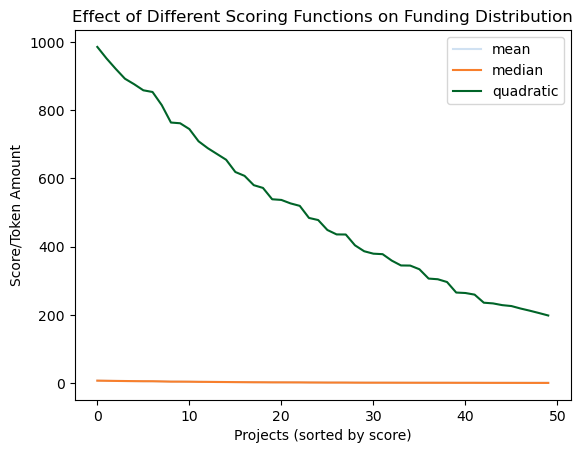

In [16]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in tqdm(sim_configs):
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        #print(f"Project {project.project_id} votes: {votes}")  # Debugging line for votes
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
            print(f"Project {project.project_id} votes: {votes}")  # Debugging line for votes
        
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
            print(f"Project {project.project_id} votes: {votes}")  # Debugging line for votes
        
        project.token_amount = score
        project_scores.append(score)
        #print(f"Project {project.project_id} ({score_fn}): {score}")  # Debugging line for scores
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


In [ ]:
#1 check vote inputs to ensure they are same0.645004469098942, 0.22708577913211725 0.645004469098942, 0.22708577913211725

In [ ]:
# 0.645004469098942, 0.22708577913211725 #

#

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.73it/s]


Mismatch in votes for Project 0
Mismatch in votes for Project 1
Mismatch in votes for Project 2
Mismatch in votes for Project 3
Mismatch in votes for Project 4
Mismatch in votes for Project 5
Mismatch in votes for Project 6
Mismatch in votes for Project 7
Mismatch in votes for Project 8
Mismatch in votes for Project 9
Mismatch in votes for Project 10
Mismatch in votes for Project 11
Mismatch in votes for Project 12
Mismatch in votes for Project 13
Mismatch in votes for Project 14
Mismatch in votes for Project 15
Mismatch in votes for Project 16
Mismatch in votes for Project 17
Mismatch in votes for Project 18
Mismatch in votes for Project 19
Mismatch in votes for Project 20
Mismatch in votes for Project 21
Mismatch in votes for Project 22
Mismatch in votes for Project 23
Mismatch in votes for Project 24
Mismatch in votes for Project 25
Mismatch in votes for Project 26
Mismatch in votes for Project 27
Mismatch in votes for Project 28
Mismatch in votes for Project 29
Mismatch in votes fo

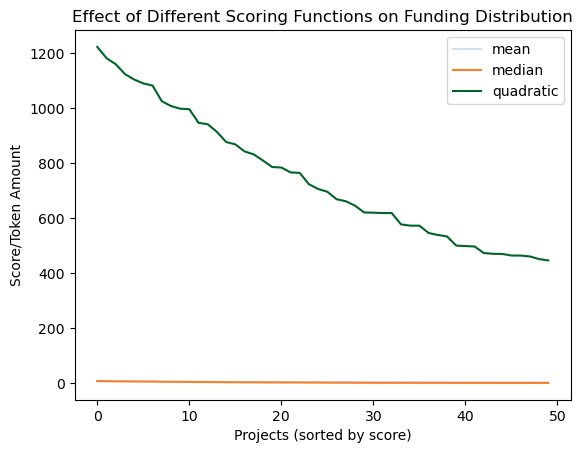

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []
project_votes_dict = {}

# Run simulations for different scoring functions
for score_fn, q in tqdm(sim_configs):
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Store votes for comparison
    if not project_votes_dict:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            project_votes_dict[project.project_id] = votes
    else:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            if project_votes_dict[project.project_id] != votes:
                print(f"Mismatch in votes for Project {project.project_id}")
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 95.12it/s]


no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
n

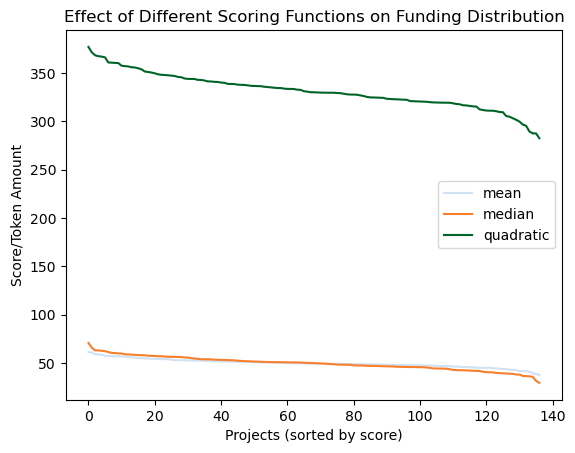

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm


# Round design variables
total_funds = 10000
min_vote = 0
max_vote = 100

# create badgeholder population
n = 50
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,  
        max_vote=max_vote,
        # TODO: these should be random variables
        laziness=1,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

#print(len(badgeholders.badgeholders))

# create projects
N = 137
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,  # TODO: this should be a random variable
        owner_id=None,  # used for COI modeling
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

#print(project_population.num_projects)



# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []
project_votes_dict = {}

# Run simulations for different scoring functions

# Configuring & running Sim
badgeholders.reset_all()
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)
projects = project_population.get_projects()
simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
# Collect all votes
all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
# Count votes for each project
project_vote_counts = defaultdict(int)
for vote in all_votes:
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0

for score_fn, q in tqdm(sim_configs):
    # Store votes for comparison
    if not project_votes_dict:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            project_votes_dict[project.project_id] = votes
            print("no error")
    else:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            if project_votes_dict[project.project_id] != votes:
                print(f"Mismatch in votes for Project {project.project_id}")
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


In [ ]:
#so now it makes more sense given that most of the parameters are the same, however I

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 60.46it/s]


no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
no error
n

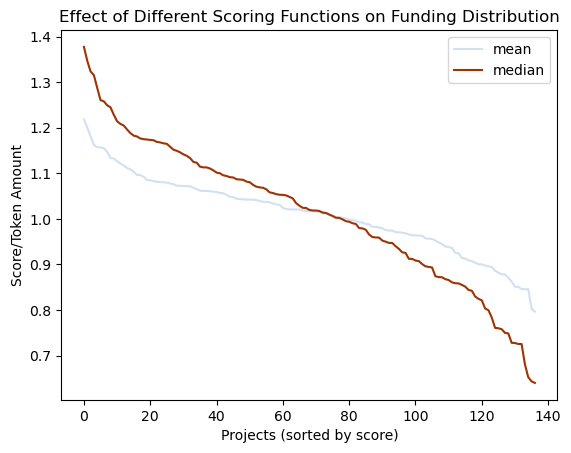

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm


# Round design variables
total_funds = 100
min_vote = 0
max_vote = 2

# create badgeholder population
n = 50
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,  
        max_vote=max_vote,
        # TODO: these should be random variables
        laziness=1,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

#print(len(badgeholders.badgeholders))

# create projects
N = 137
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,  # TODO: this should be a random variable
        owner_id=None,  # used for COI modeling
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

#print(project_population.num_projects)



# Define scoring functions and quorum values
score_fns = ['mean', 'median']#, 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []
project_votes_dict = {}

# Run simulations for different scoring functions

# Configuring & running Sim
badgeholders.reset_all()
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)
projects = project_population.get_projects()
simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
# Collect all votes
all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
# Count votes for each project
project_vote_counts = defaultdict(int)
for vote in all_votes:
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0

for score_fn, q in tqdm(sim_configs):
    # Store votes for comparison
    if not project_votes_dict:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            project_votes_dict[project.project_id] = votes
            print("no error")
    else:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            if project_votes_dict[project.project_id] != votes:
                print(f"Mismatch in votes for Project {project.project_id}")
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 116.86it/s]


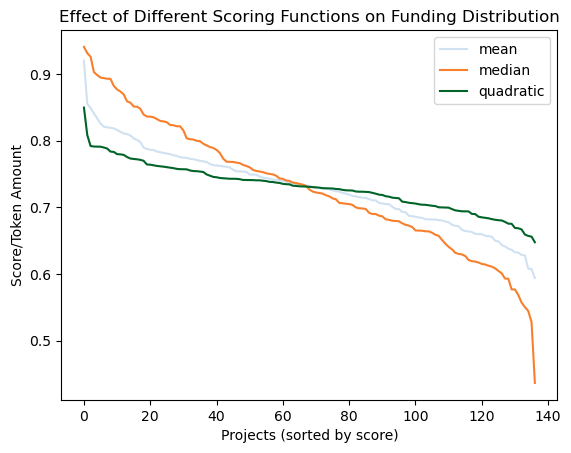

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

# Round design variables
total_funds = 100
min_vote = 0
max_vote = 10

# Create badgeholder population
n = 50
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,
        max_vote=max_vote,
        laziness=1,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

# Create projects
N = 137
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,
        owner_id=None,
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []
project_votes_dict = {}

# Run simulations for different scoring functions
badgeholders.reset_all()
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)
projects = project_population.get_projects()
simulation_obj.run(cast_votes_kwargs={'projects': projects})

# Collect all votes
all_votes = simulation_obj.badgeholder_population.get_all_votes()

# Count votes for each project
project_vote_counts = defaultdict(int)
for vote in all_votes:
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0

for score_fn, q in tqdm(sim_configs):
    # Store votes for comparison
    if not project_votes_dict:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            project_votes_dict[project.project_id] = votes
    else:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            if project_votes_dict[project.project_id] != votes:
                print(f"Mismatch in votes for Project {project.project_id}")

    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = project_votes_dict[project.project_id]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        
        project.token_amount = score
        project_scores.append(score)
    
    # Normalize scores to ensure total allocation matches total funds
    total_score = sum(project_scores)
    if total_score > 0:
        project_scores = [score * total_funds / total_score for score in project_scores]

    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33.54it/s]


Project 0 - mean: votes=[9.163059428817506, 5.633154913940265, 4.435961301710694, 6.425129968857668, 3.376751246111679, 9.36954031179906, 9.581136708476233, 3.5659097911812463, 3.92156528985761, 4.597978044225743, 7.406464016549831, 6.94488258192105, 6.4851686740119145, 6.307104056376853, 9.547350124659022, 7.797198395015764, 3.34919988529101, 9.904487564128035, 9.656014546585636, 7.255627024410507, 1.574617473252511, 5.365057679718507, 5.647282769315641, 3.2848601342334796, 1.848384617517752, 1.4198251408024287, 1.6986045427486585, 4.119516163142581, 3.7888953070001907, 6.265643737074065, 3.034618609551729, 4.485328604777394, 2.750703148515675, 0.5974522299540341, 0.34848196767235384, 0.9329831969071867, 8.9383081653445, 3.5585240019500954, 2.046005212354949, 4.768675796046169, 1.6239066737723196, 5.529739580653445, 5.896418752292385, 7.116982174517226, 0.5189826886693261, 8.128308166531884, 3.633576007470982, 2.4360823052470337, 0.2581736269842516, 4.564683349488278], score=4.8180861

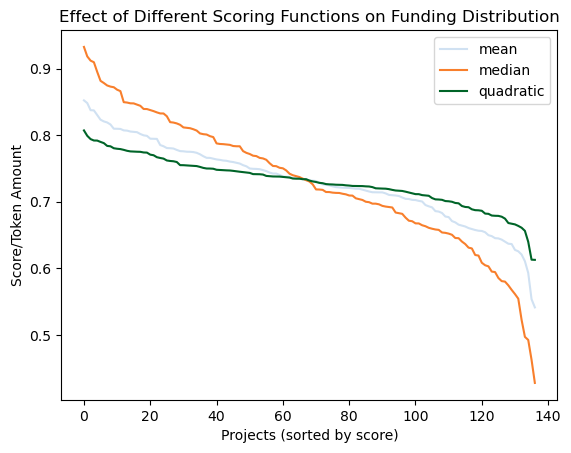

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

# Round design variables
total_funds = 100
min_vote = 0
max_vote = 10

# Create badgeholder population
n = 50
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,
        max_vote=max_vote,
        laziness=1,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

# Create projects
N = 137
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,
        owner_id=None,
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []
project_votes_dict = {}

# Run simulations for different scoring functions
badgeholders.reset_all()
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)
projects = project_population.get_projects()
simulation_obj.run(cast_votes_kwargs={'projects': projects})

# Collect all votes
all_votes = simulation_obj.badgeholder_population.get_all_votes()

# Count votes for each project
project_vote_counts = defaultdict(int)
for vote in all_votes:
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0

for score_fn, q in tqdm(sim_configs):
    # Store votes for comparison
    if not project_votes_dict:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            project_votes_dict[project.project_id] = votes
    else:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            if project_votes_dict[project.project_id] != votes:
                print(f"Mismatch in votes for Project {project.project_id}")

    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = project_votes_dict[project.project_id]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0

        # Print diagnostic information
        print(f"Project {project.project_id} - {score_fn}: votes={votes}, score={score}")

        project.token_amount = score
        project_scores.append(score)

    # Normalize scores to ensure total allocation matches total funds
    total_score = sum(project_scores)
    if total_score > 0:
        project_scores = [score * total_funds / total_score for score in project_scores]

    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.90it/s]


Project 0 - mean: votes=[1.1015358743557113, 7.0011944365947105, 3.326889549231292, 8.474025417248455, 5.631603513703017, 9.880377486732039, 9.187309837393055, 8.342294666514348, 2.281908814979218, 0.17647655039072063, 2.783398669577916, 8.456672325201062, 3.7651683412375547, 4.096495941413685, 7.100621593961919, 9.743771027705458, 6.045633467285762, 8.684948764966173, 6.631391711056831, 5.285874807583147, 3.5876926758256777, 6.760790217577332, 1.896342975480081, 6.776768116496906, 3.316530801831352, 4.619241296246777, 8.450871099093142, 8.732167933875226, 6.995391961221919, 4.813800432218135, 1.7206864186930793, 1.6544374938337314, 8.475499575035931, 1.3720125208817402, 1.4112894651640173, 1.5569613331944976, 5.016354869899285, 0.3197016329300262, 1.8796273396885899, 2.979823940481088, 4.1531097960214725, 7.4262295234551265, 3.7409435229193067, 6.397453140162241, 5.348449047162415, 5.803068601061555, 6.5456558557713365, 5.899849839735188, 6.479107250382329, 7.191116993848733], score=5

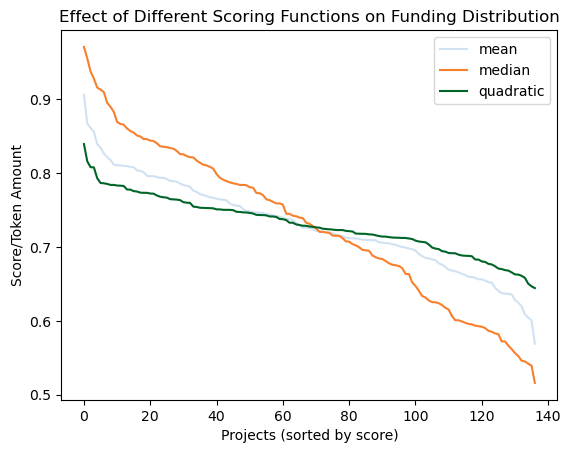

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

# Round design variables
total_funds = 100
min_vote = 0
max_vote = 10

# Create badgeholder population
n = 50
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,
        max_vote=max_vote,
        laziness=1,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

# Create projects
N = 137
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,
        owner_id=None,
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []
project_votes_dict = {}

# Run simulations for different scoring functions
badgeholders.reset_all()
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)
projects = project_population.get_projects()
simulation_obj.run(cast_votes_kwargs={'projects': projects})

# Collect all votes
all_votes = simulation_obj.badgeholder_population.get_all_votes()

# Count votes for each project
project_vote_counts = defaultdict(int)
for vote in all_votes:
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0

for score_fn, q in tqdm(sim_configs):
    # Store votes for comparison
    if not project_votes_dict:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            project_votes_dict[project.project_id] = votes
    else:
        for project in projects:
            votes = [vote.amount for vote in project.votes if vote.amount is not None]
            if project_votes_dict[project.project_id] != votes:
                print(f"Mismatch in votes for Project {project.project_id}")

    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = project_votes_dict[project.project_id]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0

        # Print diagnostic information
        print(f"Project {project.project_id} - {score_fn}: votes={votes}, score={score}")

        project.token_amount = score
        project_scores.append(score)

    # Normalize scores to ensure total allocation matches total funds
    total_score = sum(project_scores)
    print(f"Total score before normalization ({score_fn}): {total_score}")
    if total_score > 0:
        project_scores = [score * total_funds / total_score for score in project_scores]
    total_normalized_score = sum(project_scores)
    print(f"Total score after normalization ({score_fn}): {total_normalized_score}")

    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 114.87it/s]


Total score before normalization (mean): 182.63847027337152
Total score after normalization (mean): 99.99999999999987
Total score before normalization (median): 181.7610145292854
Total score after normalization (median): 99.99999999999989
Total score before normalization (quadratic): 3358.5780269055085
Total score after normalization (quadratic): 99.99999999999997


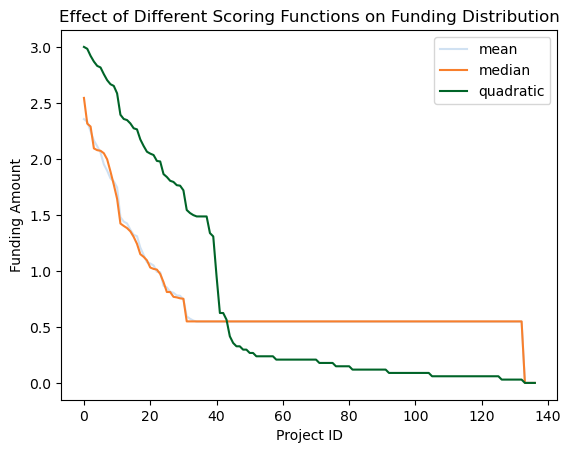

In [37]:
from voting_mechanism_design.agents.quorum_badgeholder import QuorumBadgeholder, QuorumBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.threshold_and_aggregate import ThresholdAndAggregate
from voting_mechanism_design.sim import RoundSimulation

import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

# Round design variables
total_funds = 100
min_vote = 1
max_vote = 16

# Create badgeholder population
n = 50
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,
        max_vote=max_vote,
        laziness=0,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

# Create projects
N = 137
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,
        owner_id=None,
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []
project_votes_dict = {}

# Run simulations for different scoring functions
badgeholders.reset_all()
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)
projects = project_population.get_projects()
simulation_obj.run(cast_votes_kwargs={'projects': projects})

# Collect all votes
all_votes = simulation_obj.badgeholder_population.get_all_votes()

# Count votes for each project
project_vote_counts = defaultdict(int)
for vote in all_votes:
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0

# Store votes for each project for consistency across different scoring functions
for project in projects:
    votes = [vote.amount for vote in project.votes if vote.amount is not None]
    project_votes_dict[project.project_id] = votes

# Verify that votes are consistent across different scoring functions
for score_fn, q in tqdm(sim_configs):
    project_scores = []
    for project in projects:
        votes = project_votes_dict[project.project_id]
        
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        
        project.token_amount = score
        project_scores.append(score)

        # Print diagnostic information
        #print(f"Project {project.project_id} - {score_fn}: votes={votes}, score={score}")

    # Normalize scores to ensure total allocation matches total funds
    total_score = sum(project_scores)
    print(f"Total score before normalization ({score_fn}): {total_score}")
    if total_score > 0:
        project_scores = [score * total_funds / total_score for score in project_scores]
    total_normalized_score = sum(project_scores)
    print(f"Total score after normalization ({score_fn}): {total_normalized_score}")

    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Project ID')
plt.ylabel('Funding Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


 33%|████████████████████████████████▎                                                                | 1/3 [00:00<00:00,  7.94it/s]

Total score before normalization (mean): 99.5
Total score after normalization (mean): 99.99999999999997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.99it/s]

Total score before normalization (median): 99.5
Total score after normalization (median): 99.99999999999997
Total score before normalization (quadratic): 10205.581422788868
Total score after normalization (quadratic): 100.00000000000004


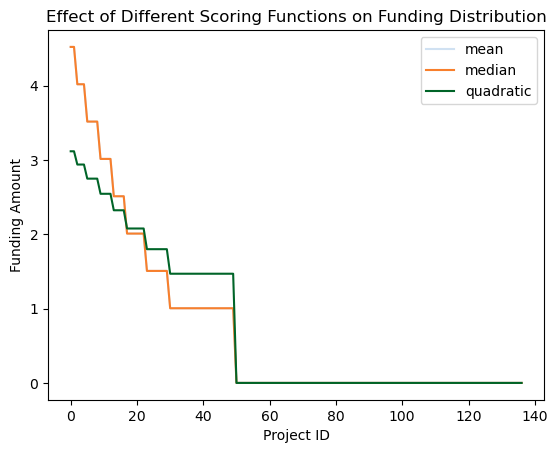

In [35]:
from voting_mechanism_design.agents.quorum_badgeholder import QuorumBadgeholder, QuorumBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.threshold_and_aggregate import ThresholdAndAggregate
from voting_mechanism_design.sim import RoundSimulation

import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

# Round design variables
total_funds = 100
min_vote = 1
max_vote = 16

# Create badgeholder population
n = 50
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,
        max_vote=max_vote,
        laziness=0,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

# Create projects
N = 137
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,
        owner_id=None,
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []
project_votes_dict = {}



# Verify that votes are consistent across different scoring functions
for score_fn, q in tqdm(sim_configs):
    # Run simulations for different scoring functions
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})

    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()

    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0

    # Store votes for each project for consistency across different scoring functions
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        project_votes_dict[project.project_id] = votes
        project_scores = []
    for project in projects:
        votes = project_votes_dict[project.project_id]
        
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        
        project.token_amount = score
        project_scores.append(score)

        # Print diagnostic information
        #print(f"Project {project.project_id} - {score_fn}: votes={votes}, score={score}")

    # Normalize scores to ensure total allocation matches total funds
    total_score = sum(project_scores)
    print(f"Total score before normalization ({score_fn}): {total_score}")
    if total_score > 0:
        project_scores = [score * total_funds / total_score for score in project_scores]
    total_normalized_score = sum(project_scores)
    print(f"Total score after normalization ({score_fn}): {total_normalized_score}")

    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Project ID')
plt.ylabel('Funding Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()
